In [1]:
import sys
import os

sys.path.insert(0, ('/').join(os.getcwd().split('/')[:-1]))
from py_wave_propagator import free_space_prop
from py_wave_propagator import volume_prop

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from matplotlib import animation
import cv2
from scipy.ndimage import gaussian_filter, median_filter
import h5py

# Free Space Propagation

0. Visualizing a 2D wave
1. Simple propagation to parallel plane
2. Propagation in \eta != 1. medium
3. Propagation in image/object space

## 0. Visualizing a 2D plane wave

In [79]:
wl = 650*1e-9

alpha = np.pi/3
beta = np.pi/2

x = np.linspace(-1e-6, 1e-6, 1000)
y = np.linspace(-1e-6, 1e-6, 1000)
X, Y = np.meshgrid(x, y, indexing='ij')

mono_wave = 1*np.exp((1j*2*np.pi/wl)*(np.cos(alpha)*X + np.cos(beta)*Y))

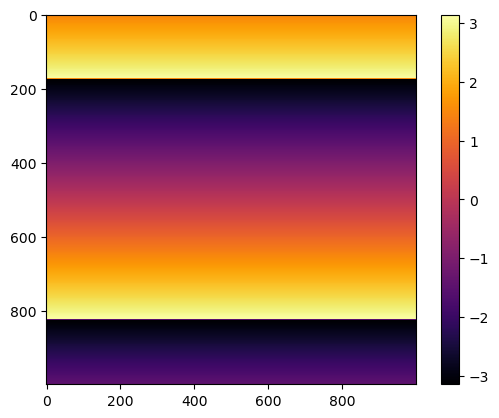

In [80]:
plt.imshow(np.angle(mono_wave), cmap=cm.inferno, vmax=np.pi, vmin=-1*np.pi)
plt.colorbar()

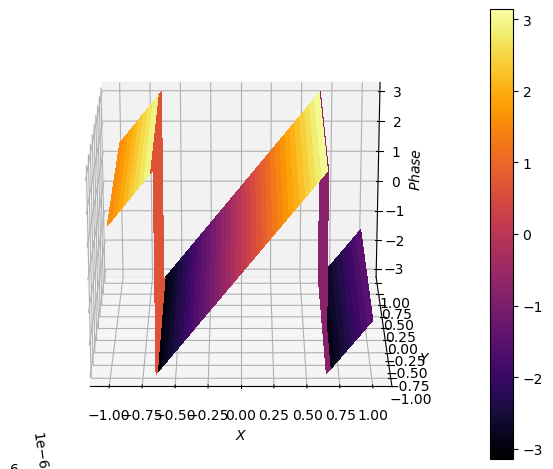

In [81]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$Y$')
ax.set_zlabel(r'$Phase$')

surf = ax.plot_surface(X, Y, np.angle(mono_wave), cmap=cm.inferno, vmax=np.pi, vmin=-1*np.pi, antialiased=False)
fig.colorbar(surf)

ax.set_zlim(-np.pi, np.pi)

ax.view_init(20, -90, 0)
plt.tight_layout()
plt.show()

## 1. Simple propagation to parallel plane

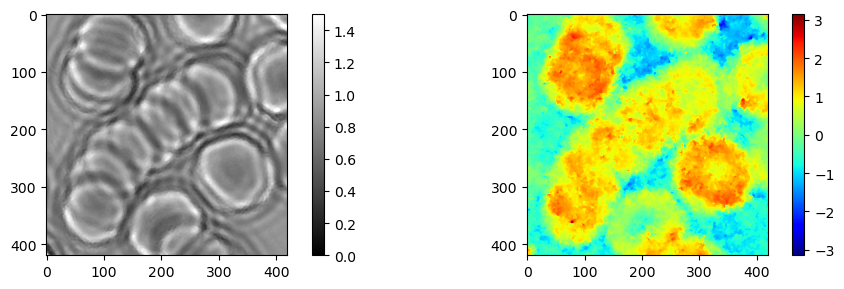

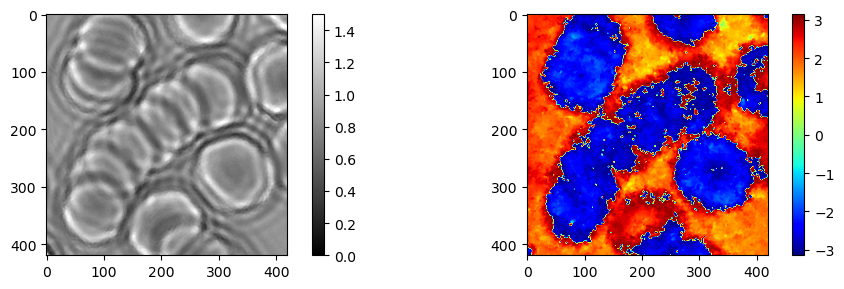

In [2]:
wl = 532*1e-9
Nx = Ny = 420
dx = dy = 6.45e-6

# sample
sample_name = '../outputs/Reconstruction/blood_01_01.mat'
A = np.array(h5py.File(sample_name, 'r').get('A'))[200:620, 200:620]
P = gaussian_filter(2*np.pi/wl*np.array(h5py.File(sample_name, 'r').get('phi'))*6.45e-6**2/1.43e-3, 0.003)[200:620, 200:620] # phase in radians

wave_0 = A*np.exp(1j*P)
wave_0 = wave_0.T

wave_z1 = volume_prop.propagate(
    wave_0, wl, [Nx*dx, Ny*dy], 5e-6, padding=210, direction='forward', bandlimited=False
    )

fig, axs = plt.subplots(1, 2, figsize=(10, 3), tight_layout=True)
cp_amp = axs[0].imshow(np.abs(wave_0)**2, vmax=1.5, vmin=0., cmap='gray')
cp_ang = axs[1].imshow((np.angle(wave_0)), vmin=-1*np.pi, vmax=np.pi, cmap='jet')

plt.colorbar(cp_amp, ax=axs[0])
plt.colorbar(cp_ang, ax=axs[1])

plt.show()


fig, axs = plt.subplots(1, 2, figsize=(10, 3), tight_layout=True)
cp_amp = axs[0].imshow(np.abs(wave_z1)**2, vmax=1.5, vmin=0., cmap='gray')
cp_ang = axs[1].imshow(np.angle(wave_z1), vmin=-1*np.pi, vmax=np.pi, cmap='jet')

plt.colorbar(cp_amp, ax=axs[0])
plt.colorbar(cp_ang, ax=axs[1])

plt.show()

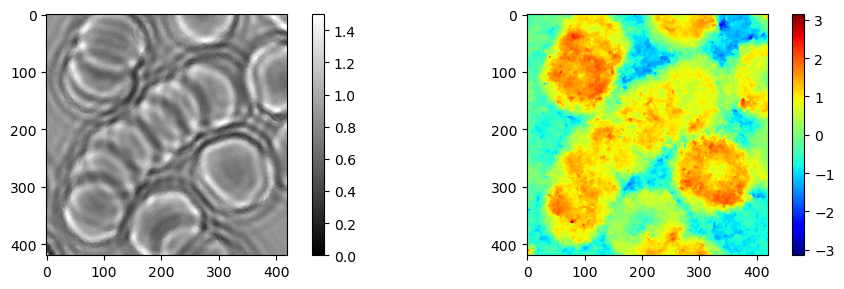

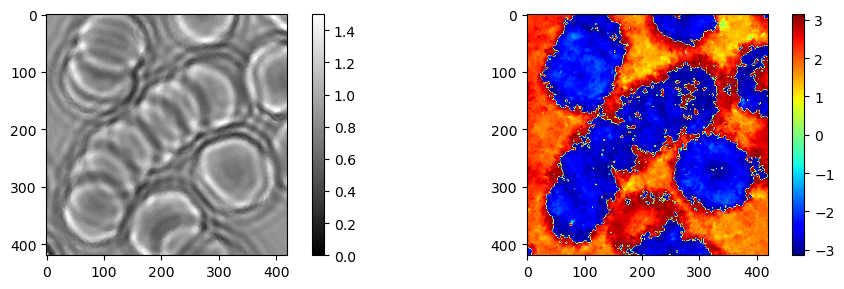

In [7]:
wl = 532*1e-9

# sample
sample_name = '../outputs/Reconstruction/blood_01_01.mat'

A = np.array(h5py.File(sample_name, 'r').get('A'))[200:620, 200:620]
P = gaussian_filter(2*np.pi/wl*np.array(h5py.File(sample_name, 'r').get('phi'))*6.45e-6**2/1.43e-3, 0.3)[200:620, 200:620] # phase in radians

wave_0 = A*np.exp(1j*P)
wave_0 = wave_0.T

wave_obj = free_space_prop.Wave2d(
    numPx = [420, 420], 
    sizePx = [6.45e-6, 6.45e-6], 
    wl = wl
)

wave_obj.wavefield(wave_0)

fig, axs = plt.subplots(1, 2, figsize=(10, 3), tight_layout=True)
cp_amp = axs[0].imshow(np.abs(wave_obj.wavefield_z0)**2, vmax=1.5, vmin=0., cmap='gray')
cp_ang = axs[1].imshow((np.angle(wave_obj.wavefield_z0)), vmin=-1*np.pi, vmax=np.pi, cmap='jet')

plt.colorbar(cp_amp, ax=axs[0])
plt.colorbar(cp_ang, ax=axs[1])

plt.show()

_ = wave_obj.propogate(5e-6)

fig, axs = plt.subplots(1, 2, figsize=(10, 3), tight_layout=True)
cp_amp = axs[0].imshow(np.abs(wave_obj.wavefield_z1)**2, vmax=1.5, vmin=0., cmap='gray')
cp_ang = axs[1].imshow(np.angle(wave_obj.wavefield_z1), vmin=-1*np.pi, vmax=np.pi, cmap='jet')

plt.colorbar(cp_amp, ax=axs[0])
plt.colorbar(cp_ang, ax=axs[1])

plt.show()

In [6]:
wave_obj.setup_limit_info()

Max Freq and Angle the camera/plane can record without aliasing: 77519.37984496124 cycles/m | 0.08248062015503876 radians
Max Freq and Angle the setup allows (freqs > do not reach the next plane): (447719.72249808314, 447719.72249808314) cycles/m | (0.23818689236898025, 0.23818689236898025) radians


## 2. Magnification effects: simple multiply the size of the pixels with mag.
## 3. Prop in medium with RI=\eta: wl = wl/\eta